# Neural Collaborative Filtering for Personalized Ranking

The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install -U mxnet-cu101==1.7.0
!pip install d2l==0.16.2


This section moves beyond explicit feedback, introducing the neural collaborative filtering (NCF) framework for recommendation with implicit feedback. Implicit feedback is pervasive in recommender systems. Actions such as Clicks, buys, and watches are common implicit feedback which are easy to collect and indicative of users' preferences. The model we will introduce, titled NeuMF :cite:`He.Liao.Zhang.ea.2017`, short for neural matrix factorization, aims to address the personalized ranking task with implicit feedback. This model leverages the flexibility and non-linearity of neural networks to replace dot products of matrix factorization, aiming at enhancing the model expressiveness. In specific, this model is structured with two subnetworks including generalized matrix factorization (GMF) and MLP and models the interactions from two pathways instead of simple inner products. The outputs of these two networks are concatenated for the final prediction scores calculation. Unlike the rating prediction task in AutoRec, this model generates a ranked recommendation list to each user based on the implicit feedback. We will use the personalized ranking loss introduced in the last section to train this model.

## The NeuMF model

As aforementioned, NeuMF fuses two subnetworks. The GMF is a generic neural network version of matrix factorization where the input is the elementwise product of user and item latent factors. It consists of two neural layers:

$$
\mathbf{x} = \mathbf{p}_u \odot \mathbf{q}_i \\
\hat{y}_{ui} = \alpha(\mathbf{h}^\top \mathbf{x}),
$$

where $\odot$ denotes the Hadamard product of vectors. $\mathbf{P} \in \mathbb{R}^{m \times k}$  and $\mathbf{Q} \in \mathbb{R}^{n \times k}$ corespond to user and item latent matrix respectively. $\mathbf{p}_u \in \mathbb{R}^{ k}$ is the $u^\mathrm{th}$ row of $P$ and $\mathbf{q}_i \in \mathbb{R}^{ k}$ is the $i^\mathrm{th}$ row of $Q$.  $\alpha$ and $h$ denote the activation function and weight of the output layer. $\hat{y}_{ui}$ is the prediction score of the user $u$ might give to the item $i$.

Another component of this model is MLP. To enrich model flexibility, the MLP subnetwork does not share user and item embeddings with GMF. It uses the concatenation of user and item embeddings as input. With the complicated connections and nonlinear transformations, it is capable of estimating the intricate interactions between users and items. More precisely, the MLP subnetwork is defined as:

$$
\begin{aligned}
z^{(1)} &= \phi_1(\mathbf{U}_u, \mathbf{V}_i) = \left[ \mathbf{U}_u, \mathbf{V}_i \right] \\
\phi^{(2)}(z^{(1)})  &= \alpha^1(\mathbf{W}^{(2)} z^{(1)} + b^{(2)}) \\
&... \\
\phi^{(L)}(z^{(L-1)}) &= \alpha^L(\mathbf{W}^{(L)} z^{(L-1)} + b^{(L)})) \\
\hat{y}_{ui} &= \alpha(\mathbf{h}^\top\phi^L(z^{(L-1)}))
\end{aligned}
$$

where $\mathbf{W}^*, \mathbf{b}^*$ and $\alpha^*$ denote the weight matrix, bias vector, and activation function. $\phi^*$ denotes the function of the corresponding layer. $\mathbf{z}^*$ denotes the output of corresponding layer.

To fuse the results of GMF and MLP, instead of simple addition, NeuMF concatenates the second last layers of two subnetworks to create a feature vector which can be passed to the further layers. Afterwards, the ouputs are projected with matrix $\mathbf{h}$ and a sigmoid activation function. The prediction layer is formulated as:
$$
\hat{y}_{ui} = \sigma(\mathbf{h}^\top[\mathbf{x}, \phi^L(z^{(L-1)})]).
$$

The following figure illustrates the model architecture of NeuMF.

![Illustration of the NeuMF model](https://github.com/d2l-ai/d2l-en-colab/blob/master/img/rec-neumf.svg?raw=1)


In [ ]:
import random
import mxnet as mx
from mxnet import autograd, gluon, np, npx
from mxnet.gluon import nn
from d2l import mxnet as d2l

npx.set_np()

## Model Implementation
The following code implements the NeuMF model. It consists of a generalized matrix factorization model and a multi-layered perceptron with different user and item embedding vectors. The structure of the MLP is controlled with the parameter `nums_hiddens`. ReLU is used as the default activation function.


In [ ]:
class NeuMF(nn.Block):
    def __init__(self, num_factors, num_users, num_items, nums_hiddens,
                 **kwargs):
        super(NeuMF, self).__init__(**kwargs)
        self.P = nn.Embedding(num_users, num_factors)
        self.Q = nn.Embedding(num_items, num_factors)
        self.U = nn.Embedding(num_users, num_factors)
        self.V = nn.Embedding(num_items, num_factors)
        self.mlp = nn.Sequential()
        for num_hiddens in nums_hiddens:
            self.mlp.add(
                nn.Dense(num_hiddens, activation='relu', use_bias=True))
        self.prediction_layer = nn.Dense(1, activation='sigmoid',
                                         use_bias=False)

    def forward(self, user_id, item_id):
        p_mf = self.P(user_id)
        q_mf = self.Q(item_id)
        gmf = p_mf * q_mf
        p_mlp = self.U(user_id)
        q_mlp = self.V(item_id)
        mlp = self.mlp(np.concatenate([p_mlp, q_mlp], axis=1))
        con_res = np.concatenate([gmf, mlp], axis=1)
        return self.prediction_layer(con_res)

## Customized Dataset with Negative Sampling

For pairwise ranking loss, an important step is negative sampling. For each user, the items that a user has not interacted with are candidate items (unobserved entries). The following function takes users identity and candidate items as input, and samples negative items randomly for each user from the candidate set of that user. During the training stage, the model ensures that the items that a user likes to be ranked higher than items he dislikes or has not interacted with.


In [ ]:
class PRDataset(gluon.data.Dataset):
    def __init__(self, users, items, candidates, num_items):
        self.users = users
        self.items = items
        self.cand = candidates
        self.all = set([i for i in range(num_items)])

    def __len__(self):
        return len(self.users)

    def __getitem__(self, idx):
        neg_items = list(self.all - set(self.cand[int(self.users[idx])]))
        indices = random.randint(0, len(neg_items) - 1)
        return self.users[idx], self.items[idx], neg_items[indices]

## Evaluator
In this section, we adopt the splitting by time strategy to construct the training and test sets. Two evaluation measures including hit rate at given cutting off $\ell$ ($\text{Hit}@\ell$) and area under the ROC curve (AUC) are used to assess the model effectiveness.  Hit rate at given position $\ell$ for each user indicates that whether the recommended item is included in the top $\ell$ ranked list. The formal definition is as follows:

$$
\text{Hit}@\ell = \frac{1}{m} \sum_{u \in \mathcal{U}} \textbf{1}(rank_{u, g_u} <= \ell),
$$

where $\textbf{1}$ denotes an indicator function that is equal to one if the ground truth item is ranked in the top $\ell$ list, otherwise it is equal to zero. $rank_{u, g_u}$ denotes the ranking of the ground truth item $g_u$ of the user $u$ in the recommendation list (The ideal ranking is 1). $m$ is the number of users. $\mathcal{U}$ is the user set.

The definition of AUC is as follows:

$$
\text{AUC} = \frac{1}{m} \sum_{u \in \mathcal{U}} \frac{1}{|\mathcal{I} \backslash S_u|} \sum_{j \in I \backslash S_u} \textbf{1}(rank_{u, g_u} < rank_{u, j}),
$$

where $\mathcal{I}$ is the item set. $S_u$ is the candidate items of user $u$. Note that many other evaluation protocols such as precision, recall and normalized discounted cumulative gain (NDCG) can also be used.

The following function calculates the hit counts and AUC for each user.


In [ ]:
#@save
def hit_and_auc(rankedlist, test_matrix, k):
    hits_k = [(idx, val) for idx, val in enumerate(rankedlist[:k])
              if val in set(test_matrix)]
    hits_all = [(idx, val) for idx, val in enumerate(rankedlist)
                if val in set(test_matrix)]
    max = len(rankedlist) - 1
    auc = 1.0 * (max - hits_all[0][0]) / max if len(hits_all) > 0 else 0
    return len(hits_k), auc

Then, the overall Hit rate and AUC are calculated as follows.


In [ ]:
#@save
def evaluate_ranking(net, test_input, seq, candidates, num_users, num_items,
                     devices):
    ranked_list, ranked_items, hit_rate, auc = {}, {}, [], []
    all_items = set([i for i in range(num_users)])
    for u in range(num_users):
        neg_items = list(all_items - set(candidates[int(u)]))
        user_ids, item_ids, x, scores = [], [], [], []
        [item_ids.append(i) for i in neg_items]
        [user_ids.append(u) for _ in neg_items]
        x.extend([np.array(user_ids)])
        if seq is not None:
            x.append(seq[user_ids, :])
        x.extend([np.array(item_ids)])
        test_data_iter = gluon.data.DataLoader(gluon.data.ArrayDataset(*x),
                                               shuffle=False,
                                               last_batch="keep",
                                               batch_size=1024)
        for index, values in enumerate(test_data_iter):
            x = [
                gluon.utils.split_and_load(v, devices, even_split=False)
                for v in values]
            scores.extend([list(net(*t).asnumpy()) for t in zip(*x)])
        scores = [item for sublist in scores for item in sublist]
        item_scores = list(zip(item_ids, scores))
        ranked_list[u] = sorted(item_scores, key=lambda t: t[1], reverse=True)
        ranked_items[u] = [r[0] for r in ranked_list[u]]
        temp = hit_and_auc(ranked_items[u], test_input[u], 50)
        hit_rate.append(temp[0])
        auc.append(temp[1])
    return np.mean(np.array(hit_rate)), np.mean(np.array(auc))

## Training and Evaluating the Model

The training function is defined below. We train the model in the pairwise manner.


In [ ]:
#@save
def train_ranking(net, train_iter, test_iter, loss, trainer, test_seq_iter,
                  num_users, num_items, num_epochs, devices, evaluator,
                  candidates, eval_step=1):
    timer, hit_rate, auc = d2l.Timer(), 0, 0
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                            legend=['test hit rate', 'test AUC'])
    for epoch in range(num_epochs):
        metric, l = d2l.Accumulator(3), 0.
        for i, values in enumerate(train_iter):
            input_data = []
            for v in values:
                input_data.append(gluon.utils.split_and_load(v, devices))
            with autograd.record():
                p_pos = [net(*t) for t in zip(*input_data[0:-1])]
                p_neg = [
                    net(*t) for t in zip(*input_data[0:-2], input_data[-1])]
                ls = [loss(p, n) for p, n in zip(p_pos, p_neg)]
            [l.backward(retain_graph=False) for l in ls]
            l += sum([l.asnumpy() for l in ls]).mean() / len(devices)
            trainer.step(values[0].shape[0])
            metric.add(l, values[0].shape[0], values[0].size)
            timer.stop()
        with autograd.predict_mode():
            if (epoch + 1) % eval_step == 0:
                hit_rate, auc = evaluator(net, test_iter, test_seq_iter,
                                          candidates, num_users, num_items,
                                          devices)
                animator.add(epoch + 1, (hit_rate, auc))
    print(f'train loss {metric[0] / metric[1]:.3f}, '
          f'test hit rate {float(hit_rate):.3f}, test AUC {float(auc):.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(devices)}')

Now, we can load the MovieLens 100k dataset and train the model. Since there are only ratings in the MovieLens dataset, with some losses of accuracy, we binarize these ratings to zeros and ones. If a user rated an item, we consider the implicit feedback as one, otherwise as zero. The action of rating an item can be treated as a form of providing implicit feedback.  Here, we split the dataset in the `seq-aware` mode where users' latest interacted items are left out for test.


In [ ]:
batch_size = 1024
df, num_users, num_items = d2l.read_data_ml100k()
train_data, test_data = d2l.split_data_ml100k(df, num_users, num_items,
                                              'seq-aware')
users_train, items_train, ratings_train, candidates = d2l.load_data_ml100k(
    train_data, num_users, num_items, feedback="implicit")
users_test, items_test, ratings_test, test_iter = d2l.load_data_ml100k(
    test_data, num_users, num_items, feedback="implicit")
train_iter = gluon.data.DataLoader(
    PRDataset(users_train, items_train, candidates, num_items), batch_size,
    True, last_batch="rollover", num_workers=d2l.get_dataloader_workers())

We then create and initialize the model. we use a three-layer MLP with constant hidden size 10.


In [ ]:
devices = d2l.try_all_gpus()
net = NeuMF(10, num_users, num_items, nums_hiddens=[10, 10, 10])
net.initialize(ctx=devices, force_reinit=True, init=mx.init.Normal(0.01))

The following code trains the model.


train loss 16.982, test hit rate 0.075, test AUC 0.531
11.5 examples/sec on [gpu(0), gpu(1)]


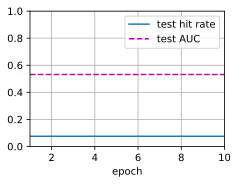

In [ ]:
lr, num_epochs, wd, optimizer = 0.01, 10, 1e-5, 'adam'
loss = d2l.BPRLoss()
trainer = gluon.Trainer(net.collect_params(), optimizer, {
    "learning_rate": lr,
    'wd': wd})
train_ranking(net, train_iter, test_iter, loss, trainer, None, num_users,
              num_items, num_epochs, devices, evaluate_ranking, candidates)

## Summary

* Adding nonlinearity to matrix factorization model is beneficial for improving the model capability and effectiveness.
* NeuMF is a combination of matrix factorization and multilayer perceptron. The multilayer perceptron takes the concatenation of user and item embeddings as the input.

## Exercises

* Vary the size of latent factors. How the size of latent factors impact the model performance?
* Vary the architectures (e.g., number of layers, number of neurons of each layer) of the MLP to check the its impact on the performance.
* Try different optimizers, learning rate and weight decay rate.
* Try to use hinge loss defined in the last section to optimize this model.


[Discussions](https://discuss.d2l.ai/t/403)
